In [1]:
!pip install recommenders
!pip install scrapbook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import itertools
import math
import os
from tempfile import TemporaryDirectory

import numpy as np
import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets import movielens
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

     |████████████████████████████████| 335 kB 9.3 MB/s 
     |████████████████████████████████| 12.4 MB 35.6 MB/s 
     |████████████████████████████████| 310 kB 56.9 MB/s 
     |████████████████████████████████| 1.5 MB 36.8 MB/s 
     |████████████████████████████████| 11.8 MB 27.1 MB/s 
     |████████████████████████████████| 636 kB 39.5 MB/s 
     |████████████████████████████████| 197 kB 14.9 MB/s 
     |████████████████████████████████| 4.2 MB 27.7 MB/s 
     |████████████████████████████████| 61 kB 7.9 MB/s 
     |████████████████████████████████| 749 kB 44.2 MB/s 
     |████████████████████████████████| 11.1 MB 27.1 MB/s 
     |████████████████████████████████| 384 kB 39.5 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 6.6 MB 48.2 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705373 sha256=fb18b14420c00c43c8576453a51128d2f788d3a703b5ea6f5124ae6cc50849b0
  Stored in directory: /roo

In [2]:
"""Parameters (papermill)"""

# Recommend top k items
TOP_K = 10
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = './outputs/model'
# Model checkpoints directory. If None, use temp-dir.
MODEL_DIR = None

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [3]:
if MODEL_DIR is None:
    TMP_DIR = TemporaryDirectory()
    model_dir = TMP_DIR.name
else:
    if os.path.exists(MODEL_DIR) and os.listdir(MODEL_DIR):
        raise ValueError(
            "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR)
        )
    TMP_DIR = None
    model_dir = MODEL_DIR

In [4]:
use_preset = (TRAIN_PICKLE_PATH is not None and TEST_PICKLE_PATH is not None)
if not use_preset:
    # The genres of each movie are returned as '|' separated string, e.g. "Animation|Children's|Comedy".
    data = movielens.load_pandas_df(
        size=MOVIELENS_DATA_SIZE,
        header=[USER_COL, ITEM_COL, RATING_COL],
        genres_col=ITEM_FEAT_COL
    )
    display(data.head())

100%|██████████| 4.81k/4.81k [00:00<00:00, 9.14kKB/s]


,userID,itemID,rating,genre
0,196,242,3.0,Comedy
1,63,242,3.0,Comedy
2,226,242,5.0,Comedy
3,154,242,3.0,Comedy
4,306,242,5.0,Comedy


In [5]:
if not use_preset and ITEM_FEAT_COL is not None:
    # Encode 'genres' into int array (multi-hot representation) to use as item features
    genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
    data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s: s.split("|"))
    ).tolist()
    print("Genres:", genres_encoder.classes_)
    display(data.head())

Genres: ['Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western' 'unknown']


,userID,itemID,rating,genre
0,196,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,63,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,226,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,154,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,306,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
if not use_preset:
    train, test = python_random_split(data, ratio=0.75, seed=RANDOM_SEED)
else:
    train = pd.read_pickle(path=TRAIN_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TRAIN_PICKLE_PATH))
    test = pd.read_pickle(path=TEST_PICKLE_PATH if DATA_DIR is None else os.path.join(DATA_DIR, TEST_PICKLE_PATH))
    data = pd.concat([train, test])

print("{} train samples and {} test samples".format(len(train), len(test)))

75000 train samples and 25000 test samples


In [7]:
# Unique items in the dataset
if ITEM_FEAT_COL is None:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
# Unique users in the dataset
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 1682 items and 943 users in the dataset


In [8]:
# Create model checkpoint every n steps. We store the model 5 times.
save_checkpoints_steps = max(1, STEPS // 5)
# Define wide (linear) and deep (dnn) features
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154, 306, 296, 34, 271, ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(242, 302, 377, 51, 346, 474, 265, 465 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154 ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(19 ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(24 ...
	 NumericColumn(key='genre', shape=(19,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [9]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

In [10]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
ranking_pool = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
    user_item_filter_df=train,  # Remove seen items
    shuffle=True,
    seed=RANDOM_SEED
)
# Define training hooks to track performance while training
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    for metrics in (RANKING_METRICS, RATING_METRICS):
        if len(metrics) > 0:
            hooks.append(
                tf_utils.evaluation_log_hook(
                    model,
                    logger=evaluation_logger,
                    true_df=test,
                    y_col=RATING_COL,
                    eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                    every_n_iter=save_checkpoints_steps,
                    model_dir=model_dir,
                    eval_fns=[evaluator.metrics[m] for m in metrics],
                    **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
                )
            )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [11]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 21)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp0ksjy6ru/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 432.8184, step = 0
INFO:tensorflow:global_step/sec: 89.5706
INFO:tensorflow:loss = 37.75402, step = 5000 (21.218 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...
INFO:tensorflow:Saving checkpoints for 10000 into /tmp/tmp0ksjy6ru/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...
INFO:tensorflow:global_step/sec: 240.429


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 18.692646, step = 10000 (56.318 sec)
INFO:tensorflow:global_step/sec: 88.6895
INFO:tensorflow:loss = 19.70553, step = 15000 (20.855 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20000...
INFO:tensorflow:Saving checkpoints for 20000 into /tmp/tmp0ksjy6ru/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20000...
INFO:tensorflow:global_step/sec: 246.276


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 36.991814, step = 20000 (53.571 sec)
INFO:tensorflow:global_step/sec: 92.479
INFO:tensorflow:loss = 27.612055, step = 25000 (20.799 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...
INFO:tensorflow:Saving checkpoints for 30000 into /tmp/tmp0ksjy6ru/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...
INFO:tensorflow:global_step/sec: 231.387


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 28.640232, step = 30000 (53.685 sec)
INFO:tensorflow:global_step/sec: 90.3631
INFO:tensorflow:loss = 28.580763, step = 35000 (23.262 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40000...
INFO:tensorflow:Saving checkpoints for 40000 into /tmp/tmp0ksjy6ru/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40000...
INFO:tensorflow:global_step/sec: 234.004


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 25.666756, step = 40000 (56.798 sec)
INFO:tensorflow:global_step/sec: 88.3226
INFO:tensorflow:loss = 21.79755, step = 45000 (21.173 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50000...
INFO:tensorflow:Saving checkpoints for 50000 into /tmp/tmp0ksjy6ru/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50000...
INFO:tensorflow:Loss for final step: 23.8342.


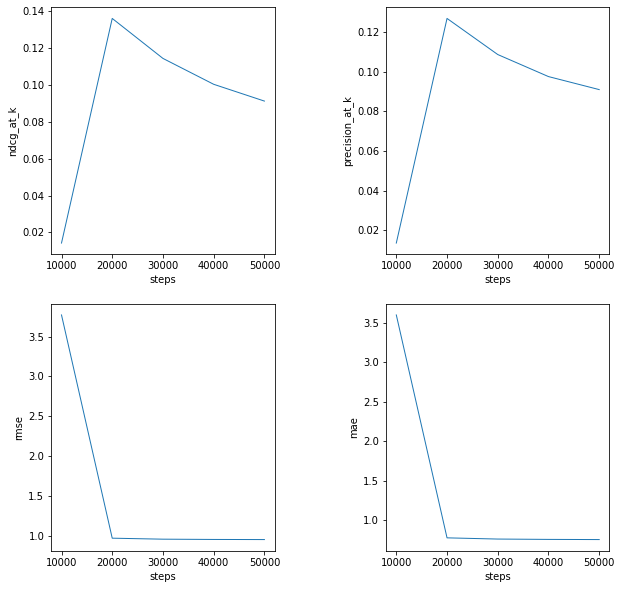

In [12]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

In [14]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp0ksjy6ru/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'rmse': 0.9525897008089568, 'mae': 0.7576178740453721}


In [18]:
import json
with open('rating_result.json', 'w+', encoding='utf-8') as f:
    json.dump(rating_results, f)

In [17]:
ranking_pool.to_csv('hybrid_result.csv')
